![](https://images.unsplash.com/photo-1602084551218-a28205125639?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2070&q=80)

<div class = 'alert alert-block alert-info'
     style = 'background-color:#4c1c84;
              color:#eeebf1;
              border-width:5px;
              border-color:#4c1c84;
              font-family:Comic Sans MS;
              border-radius: 50px 50px'>
    <p style = 'font-size:24px'>Exp 031</p>
    <a href = "#Config"
       style = "color:#eeebf1;
                font-size:14px">1.Config</a><br>
    <a href = "#Settings"
       style = "color:#eeebf1;
                font-size:14px">2.Settings</a><br>
    <a href = "#Data-Load"
       style = "color:#eeebf1;
                font-size:14px">3.Data Load</a><br>
    <a href = "#Pytorch-Settings"
       style = "color:#eeebf1;
                font-size:14px">4.Pytorch Settings</a><br>
    <a href = "#Training"
       style = "color:#eeebf1;
                font-size:14px">5.Training</a><br>
</div>

<p style = 'font-size:24px;
            color:#4c1c84'>
    実施したこと
</p>
    <li style = "color:#4c1c84;
                font-size:14px">使用データ:Ruddit</li>
    <li style = "color:#4c1c84;
                font-size:14px">使用モデル:unitary/toxic-bert</li>
    <li style = "color:#4c1c84;
                font-size:14px">Attentionの可視化</li>

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Config
</h1>
<br>

In [1]:
import sys
sys.path.append("../src/utils/iterative-stratification/")
sys.path.append("../src/utils/detoxify")
sys.path.append("../src/utils/coral-pytorch/")

In [3]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import copy
import math
import time
import random
import string
import psutil
import pathlib
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict
from box import Box
from typing import Optional
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

## Model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW, AutoModelForSequenceClassification
from transformers import RobertaModel, RobertaForSequenceClassification
from transformers import RobertaTokenizer
from transformers import LukeTokenizer, LukeModel, LukeConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from transformers import DebertaTokenizer, DebertaModel

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning import callbacks
from pytorch_lightning.callbacks.progress import ProgressBarBase
from pytorch_lightning import LightningDataModule, LightningDataModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar

from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import rankdata
from cuml.svm import SVR as cuml_SVR
from cuml.linear_model import Ridge as cuml_Ridge
import cudf
from detoxify import Detoxify
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from ast import literal_eval
from nltk.tokenize import TweetTokenizer
import spacy
from scipy.stats import sem
from copy import deepcopy


In [23]:
import torch

config = {
    "exp_comment":"Rudditをdetoxifyで学習",
    "seed": 42,
    "root": "/content/drive/MyDrive/kaggle/Jigsaw/raw",
    "n_fold": 5,
    "epoch": 5,
    "max_length": 256,
    "environment": "AWS",
    "project": "Jigsaw",
    "entity": "dataskywalker",
    "exp_name": "031_exp",
    "margin": 0.5,
    "train_fold": [0, 1, 2, 3, 4],

    "trainer": {
        "gpus": 1,
        "accumulate_grad_batches": 8,
        "progress_bar_refresh_rate": 1,
        "fast_dev_run": True,
        "num_sanity_val_steps": 0,
    },

    "train_loader": {
        "batch_size": 8,
        "shuffle": True,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": True,
    },

    "valid_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "test_loader": {
        "batch_size": 8,
        "shuffle": False,
        "num_workers": 1,
        "pin_memory": True,
        "drop_last": False,
    },

    "backbone": {
        "name": "unitary/toxic-bert",
        "output_dim": 1,
    },

    "optimizer": {
        "name": "torch.optim.AdamW",
        "params": {
            "lr": 1e-6,
        },
    },

    "scheduler": {
        "name": "torch.optim.lr_scheduler.CosineAnnealingWarmRestarts",
        "params": {
            "T_0": 20,
            "eta_min": 0,
        },
    },

    "loss": "nn.MSELoss",
}

config = Box(config)
config.tokenizer = AutoTokenizer.from_pretrained(config.backbone.name)
config.model = AutoModelForSequenceClassification.from_pretrained(config.backbone.name)
# pprint(config)

In [24]:
config.tokenizer.save_pretrained(f"../data/processed/{config.backbone.name}")

pretrain_model = AutoModelForSequenceClassification.from_pretrained(config.backbone.name)
pretrain_model.save_pretrained(f"../data/processed/{config.backbone.name}")

In [25]:
# 個人的にAWSやKaggle環境やGoogle Colabを行ったり来たりしているのでまとめています
import os
import sys
from pathlib import Path

if config.environment == 'AWS':
    
    INPUT_DIR = Path('/mnt/work/data/kaggle/Jigsaw/')
    MODEL_DIR = Path(f'../models/{config.exp_name}/')
    OUTPUT_DIR = Path(f'../data/interim/{config.exp_name}/')
    UTIL_DIR = Path('/mnt/work/shimizu/kaggle/PetFinder/src/utils')
    
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    print(f"Your environment is 'AWS'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}\nUTIL_DIR is {UTIL_DIR}")
    
    
elif config.environment == 'Kaggle':
    INPUT_DIR = Path('../input/*****')
    MODEL_DIR = Path('./')
    OUTPUT_DIR = Path('./')
    print(f"Your environment is 'Kaggle'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")

    
elif config.environment == 'Colab':
    INPUT_DIR = Path('/content/drive/MyDrive/kaggle/Jigsaw/raw')
    BASE_DIR = Path("/content/drive/MyDrive/kaggle/Jigsaw/interim")

    MODEL_DIR = BASE_DIR / f'{config.exp_name}'
    OUTPUT_DIR = BASE_DIR / f'{config.exp_name}/'

    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
    if not os.path.exists(INPUT_DIR):
        print('Please Mount your Google Drive.')
    else:
        print(f"Your environment is 'Colab'.\nINPUT_DIR is {INPUT_DIR}\nMODEL_DIR is {MODEL_DIR}\nOUTPUT_DIR is {OUTPUT_DIR}")
        
else:
    print("Please choose 'AWS' or 'Kaggle' or 'Colab'.\nINPUT_DIR is not found.")

Your environment is 'AWS'.
INPUT_DIR is /mnt/work/data/kaggle/Jigsaw
MODEL_DIR is ../models/031_exp
OUTPUT_DIR is ../data/interim/031_exp
UTIL_DIR is /mnt/work/shimizu/kaggle/PetFinder/src/utils


In [26]:
# Seed固定
seed_everything(config.seed)

42

In [27]:
## 処理時間計測
@contextmanager
def timer(name:str, slack:bool=False):
    t0 = time.time()
    p = psutil.Process(os.getpid())
    m0 = p.memory_info()[0] / 2. ** 30
    print(f'<< {name} >> Start')
    yield
    
    m1 = p.memory_info()[0] / 2. ** 30
    delta = m1 - m0
    sign = '+' if delta >= 0 else '-'
    delta = math.fabs(delta)
    
    print(f"<< {name} >> {m1:.1f}GB({sign}{delta:.1f}GB):{time.time() - t0:.1f}sec", file=sys.stderr)

<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Data Load
</h1>
<br>

In [28]:
## Data Check
for dirnames, _, filenames in os.walk(INPUT_DIR):
    
    for filename in filenames:

        print(f'{dirnames}/{filename}')

/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv
/mnt/work/data/kaggle/Jigsaw/sample_submission.csv
/mnt/work/data/kaggle/Jigsaw/validation_data.csv


In [29]:
val_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/validation_data.csv")
test_df = pd.read_csv("/mnt/work/data/kaggle/Jigsaw/comments_to_score.csv")

display(val_df.head())
display(test_df.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal; 
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center;
             border-radius: 100px 100px;">
    Ruddit
</h2>
<br>

In [33]:
train_df = pd.read_csv("../data/external/Ruddit/Dataset/ruddit_with_text.csv")

display(train_df.head())
display(train_df.shape)

,post_id,comment_id,txt,url,offensiveness_score
0,42g75o,cza1q49,> The difference in average earnings between m...,https://www.reddit.com/r/changemyview/comments...,-0.083
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based o...",https://www.reddit.com/r/changemyview/comments...,-0.022
2,42g75o,cza23qx,[deleted],https://www.reddit.com/r/changemyview/comments...,0.167
3,42g75o,cza2bw8,The assertion is that women get paid less for ...,https://www.reddit.com/r/changemyview/comments...,-0.146
4,42g75o,cza2iji,You said in the OP that's not what they're mea...,https://www.reddit.com/r/changemyview/comments...,-0.083


(5838, 5)

In [34]:
train_df = train_df[train_df["txt"]!="[deleted]"].reset_index(drop=True)
display(train_df.head())
display(train_df.shape)

,post_id,comment_id,txt,url,offensiveness_score
0,42g75o,cza1q49,> The difference in average earnings between m...,https://www.reddit.com/r/changemyview/comments...,-0.083
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based o...",https://www.reddit.com/r/changemyview/comments...,-0.022
2,42g75o,cza2bw8,The assertion is that women get paid less for ...,https://www.reddit.com/r/changemyview/comments...,-0.146
3,42g75o,cza2iji,You said in the OP that's not what they're mea...,https://www.reddit.com/r/changemyview/comments...,-0.083
4,42g75o,cza2jj3,>Men and women are not payed less for the same...,https://www.reddit.com/r/changemyview/comments...,-0.042


(5722, 5)

In [35]:
def min_max_scale(df:pd.DataFrame, col:str) -> pd.DataFrame:
    
    df["target"] = (df[col] - df[col].min())/(df[col].max() - df[col].min())

    return df

train_df = min_max_scale(train_df, "offensiveness_score")

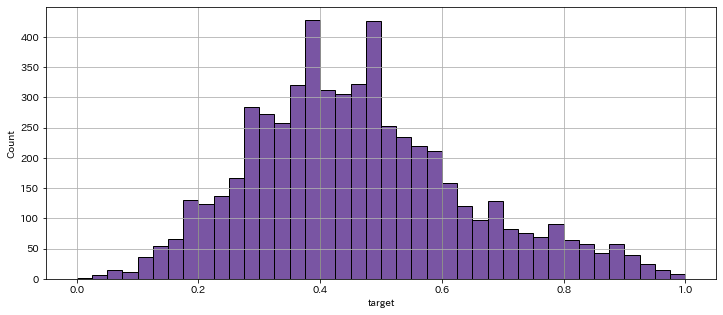

In [36]:
target_cols = ["target"]

plt.figure(figsize=(12, 5))
sns.histplot(train_df["target"], color="#4c1c84")
plt.grid()
plt.show()

In [37]:
print(f"target mean is {train_df['target'].mean():.5f}")
print(f"target std is {train_df['target'].std():.5f}")

target mean is 0.46137
target std is 0.17910


<br>
<h1 style = "font-size:45px; font-family:Comic Sans MS ; font-weight : normal; background-color: #4c1c84 ; color : #eeebf1; text-align: center; border-radius: 100px 100px;">
    Pytorch Dataset
</h1>
<br>

In [38]:
class JigsawDataset:
    
    def __init__(self, df, tokenizer, max_length, mode, target_cols):
        
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.mode = mode
        self.target_cols = target_cols
        
        if self.mode == "train":
            self.text = df["txt"].values
            self.target = df[target_cols].values
            
        elif self.mode == "valid":
            self.more_toxic = df["more_toxic"].values
            self.less_toxic = df["less_toxic"].values
            
        else:
            self.text = df["text"].values
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            text = self.text[index]
            target = self.target[index]
            
            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        elif self.mode == "valid":
            
            more_toxic = self.more_toxic[index]
            less_toxic = self.less_toxic[index]

            inputs_more_toxic = self.tokenizer.encode_plus(
                more_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )

            inputs_less_toxic = self.tokenizer.encode_plus(
                less_toxic,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            target = 1

            more_toxic_ids = inputs_more_toxic["input_ids"]
            more_toxic_mask = inputs_more_toxic["attention_mask"]
            more_token_type_ids = inputs_more_toxic["token_type_ids"]

            less_toxic_ids = inputs_less_toxic["input_ids"]
            less_toxic_mask = inputs_less_toxic["attention_mask"]
            less_token_type_ids = inputs_less_toxic["token_type_ids"]
            
            return {
                'more_toxic_ids': torch.tensor(more_toxic_ids, dtype=torch.long),
                'more_toxic_mask': torch.tensor(more_toxic_mask, dtype=torch.long),
                'more_token_type_ids': torch.tensor(more_token_type_ids, dtype=torch.long),
                
                'less_toxic_ids': torch.tensor(less_toxic_ids, dtype=torch.long),
                'less_toxic_mask': torch.tensor(less_toxic_mask, dtype=torch.long),
                'less_token_type_ids': torch.tensor(less_token_type_ids, dtype=torch.long),
                
                'target': torch.tensor(target, dtype=torch.float)
            }
        
        else:
            
            text = self.text[index]
            
            inputs_text = self.tokenizer.encode_plus(
                text,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                max_length = self.max_len,
                padding="max_length",
            )
            
            text_ids = inputs_text["input_ids"]
            text_mask = inputs_text["attention_mask"]
            text_token_type_ids = inputs_text["token_type_ids"]

            return {
                'text_ids': torch.tensor(text_ids, dtype=torch.long),
                'text_mask': torch.tensor(text_mask, dtype=torch.long),
                'text_token_type_ids': torch.tensor(text_token_type_ids, dtype=torch.long),
            }

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    DataModule
</h2>
<br>

In [39]:
class JigsawDataModule(LightningDataModule):

    def __init__(self, train_df, valid_df, test_df, cfg):

        super().__init__()
        self._train_df = train_df
        self._valid_df = valid_df
        self._test_df = test_df
        self._cfg = cfg

    def train_dataloader(self):
        dataset = JigsawDataset(
            df=self._train_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="train",
            target_cols=target_cols
            )
        return DataLoader(dataset, **self._cfg.train_loader)

    def val_dataloader(self):
        dataset = JigsawDataset(
            df=self._valid_df, 
            tokenizer=self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="valid",
            target_cols=target_cols
            )
        return DataLoader(dataset, **self._cfg.valid_loader)

    def test_dataloader(self):
        dataset = JigsawDataset(
            df=self._test_df,
            tokenizer = self._cfg.tokenizer,
            max_length=self._cfg.max_length,
            mode="test",
            target_cols=target_cols
        )

        return DataLoader(dataset, **self._cfg.test_loader)

In [40]:
## DataCheck
seed_everything(config.seed)

sample_dataloader = JigsawDataModule(train_df, val_df, test_df, config).train_dataloader()
for data in sample_dataloader:
    break

In [47]:
print(data["text_ids"].size())
print(data["text_mask"].size())
print(data["text_token_type_ids"].size())
print(data["target"].size())
print(data["target"])
output = config.model(
    data["text_ids"],
    data["text_mask"],
    data["text_token_type_ids"],
    output_hidden_states=True,
    output_attentions=True,
)
print(output["hidden_states"][-1].size(), output["attentions"][-1].size())
print(output["hidden_states"][-1][:, 0, :].size(), output["attentions"][-1].size())

torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 256])
torch.Size([8, 1])
tensor([[0.4176],
        [0.4202],
        [0.6429],
        [0.5316],
        [0.3421],
        [0.2639],
        [0.5573],
        [0.3394]])
torch.Size([8, 256, 768]) torch.Size([8, 12, 256, 256])
torch.Size([8, 768]) torch.Size([8, 12, 256, 256])


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    LigitningModule
</h2>
<br>

In [53]:
class JigsawModel(pl.LightningModule):
    
    def __init__(self, cfg, fold_num):
        
        super().__init__()
        self.cfg = cfg
        self.__build_model()
        self.criterion = eval(self.cfg.loss)()
        self.save_hyperparameters(cfg)
        self.fold_num = fold_num
        
    def __build_model(self):
        
        self.base_model = AutoModelForSequenceClassification.from_pretrained(
            self.cfg.backbone.name
        )
        print(f"Use Model: {self.cfg.backbone.name}")
        self.norm = nn.LayerNorm(768)
        self.drop = nn.Dropout(p=0.3)
        self.head = nn.Linear(768, self.cfg.backbone.output_dim)
        
    def forward(self, ids, mask, token_type_ids):
        
        output = self.base_model(
            input_ids=ids, 
            attention_mask=mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
            output_attentions=True
        )
        feature = self.norm(output["hidden_states"][-1][:, 0, :])
        out = self.drop(feature)
        out = self.head(out)
        
        return {
            "logits":out, 
            "feature":feature,
            "attention":output["attentions"], 
            "mask":mask,
        }
    
    def training_step(self, batch, batch_idx):
        
        text_ids = batch["text_ids"]
        text_mask = batch['text_mask']
        text_token_type_ids = batch['text_token_type_ids']
        targets = batch['target']
        
        outputs = self.forward(text_ids, text_mask, text_token_type_ids)
        loss = torch.sqrt(self.criterion(outputs["logits"], targets))
        
        return {
            "loss":loss,
            "targets":targets,
        }
    
    def training_epoch_end(self, training_step_outputs):

        loss_list = []

        for out in training_step_outputs:

            loss_list.extend([out["loss"].cpu().detach().tolist()])

        meanloss = sum(loss_list)/len(loss_list)

        logs = {f"train_loss/fold{self.fold_num+1}": meanloss,}

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
    def validation_step(self, batch, batch_idx):

        more_toxic_ids = batch['more_toxic_ids']
        more_toxic_mask = batch['more_toxic_mask']
        more_text_token_type_ids = batch['more_token_type_ids']
        
        less_toxic_ids = batch['less_toxic_ids']
        less_toxic_mask = batch['less_toxic_mask']
        less_text_token_type_ids = batch['less_token_type_ids']
        
        targets = batch['target']

        more_outputs = self.forward(
            more_toxic_ids, 
            more_toxic_mask,
            more_text_token_type_ids
        )
        
        less_outputs = self.forward(
            less_toxic_ids, 
            less_toxic_mask,
            less_text_token_type_ids
        )
        
        
        more_outputs = torch.sum(more_outputs["logits"], 1)
        less_outputs = torch.sum(less_outputs["logits"], 1)
        
        outputs = more_outputs - less_outputs
        logits = outputs.clone()

        logits[logits > 0] = 1
        loss = self.criterion(logits, targets)

        return {
            "loss":loss,
            "pred":outputs,
            "targets":targets,
        }
    
    
    def validation_epoch_end(self, validation_step_outputs):

        loss_list = []
        pred_list = []
        target_list = []

        for out in validation_step_outputs:
            loss_list.extend([out["loss"].cpu().detach().tolist()])
            pred_list.append(out["pred"].detach().cpu().numpy())
            target_list.append(out["targets"].detach().cpu().numpy())

        meanloss = sum(loss_list)/len(loss_list)
        pred_list = np.concatenate(pred_list)
        pred_count = sum(x>0 for x in pred_list)/len(pred_list)

        logs = {
            f"valid_loss/fold{self.fold_num+1}":meanloss,
            f"valid_acc/fold{self.fold_num+1}":pred_count,
        }

        self.log_dict(
            logs,
            on_step=False,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )
        
    def configure_optimizers(self):

        optimizer = eval(self.cfg.optimizer.name)(
            self.parameters(), **self.cfg.optimizer.params
        )

        self.scheduler = eval(self.cfg.scheduler.name)(
            optimizer, **self.cfg.scheduler.params
        )
        
        scheduler = {"scheduler": self.scheduler, "interval": "step",}

        return [optimizer], [scheduler]

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Training
</h2>
<br>

In [54]:
skf = KFold(
    n_splits=config.n_fold, 
    shuffle=True, 
    random_state=config.seed
)

for fold, (_, val_idx) in enumerate(skf.split(X=train_df, y=train_df["target"])):
    train_df.loc[val_idx, "kfold"] = int(fold)

train_df["kfold"] = train_df["kfold"].astype(int)
train_df.head()

,post_id,comment_id,txt,url,offensiveness_score,target,kfold
0,42g75o,cza1q49,> The difference in average earnings between m...,https://www.reddit.com/r/changemyview/comments...,-0.083,0.431478,2
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based o...",https://www.reddit.com/r/changemyview/comments...,-0.022,0.464133,3
2,42g75o,cza2bw8,The assertion is that women get paid less for ...,https://www.reddit.com/r/changemyview/comments...,-0.146,0.397752,3
3,42g75o,cza2iji,You said in the OP that's not what they're mea...,https://www.reddit.com/r/changemyview/comments...,-0.083,0.431478,4
4,42g75o,cza2jj3,>Men and women are not payed less for the same...,https://www.reddit.com/r/changemyview/comments...,-0.042,0.453426,4


In [56]:
## Debug
config.trainer.fast_dev_run = True
config.backbone.output_dim = len(target_cols)

for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)

    datamodule = JigsawDataModule(df_train, val_df, test_df, config)
    sample_dataloader = JigsawDataModule(df_train, val_df, test_df, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath=MODEL_DIR,
        save_weights_only=True,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['RoBERTa-Base', "Ruddit"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
#         deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForSequenceClassification │  109 M │
│ 1 │ norm       │ LayerNorm                     │  1.5 K │
│ 2 │ drop       │ Dropout                       │      0 │
│ 3 │ head       │ Linear                        │    769 │
│ 4 │ criterion  │ MSELoss                       │      0 │
└───┴────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 437

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 2.36it/s loss: 0.903 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForSequenceClassification │  109 M │
│ 1 │ norm       │ LayerNorm                     │  1.5 K │
│ 2 │ drop       │ Dropout                       │      0 │
│ 3 │ head       │ Linear                        │    769 │
│ 4 │ criterion  │ MSELoss                       │      0 │
└───┴────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 437

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:00 • 0:00:00 2.38it/s loss: 0.558 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForSequenceClassification │  109 M │
│ 1 │ norm       │ LayerNorm                     │  1.5 K │
│ 2 │ drop       │ Dropout                       │      0 │
│ 3 │ head       │ Linear                        │    769 │
│ 4 │ criterion  │ MSELoss                       │      0 │
└───┴────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 437

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:01 • 0:00:00 2.22it/s loss: 0.672 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForSequenceClassification │  109 M │
│ 1 │ norm       │ LayerNorm                     │  1.5 K │
│ 2 │ drop       │ Dropout                       │      0 │
│ 3 │ head       │ Linear                        │    769 │
│ 4 │ criterion  │ MSELoss                       │      0 │
└───┴────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 437

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:01 • 0:00:00 2.03it/s loss: 0.69 v_num:  

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForSequenceClassification │  109 M │
│ 1 │ norm       │ LayerNorm                     │  1.5 K │
│ 2 │ drop       │ Dropout                       │      0 │
│ 3 │ head       │ Linear                        │    769 │
│ 4 │ criterion  │ MSELoss                       │      0 │
└───┴────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 437

Output()

Epoch 0    ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 0:00:01 • 0:00:00 1.89it/s loss: 0.488 v_num:  

In [ ]:
## Training
config.trainer.fast_dev_run = False
config.backbone.output_dim = len(target_cols)

for fold in config.train_fold:
    
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    df_train = train_df[train_df.kfold != fold].reset_index(drop=True)

    datamodule = JigsawDataModule(df_train, val_df, test_df, config)
    sample_dataloader = JigsawDataModule(df_train, val_df, test_df, config).train_dataloader()

    config.scheduler.params.T_0 = config.epoch * len(sample_dataloader)
    model = JigsawModel(config, fold)
    lr_monitor = callbacks.LearningRateMonitor()

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath=MODEL_DIR,
        save_weights_only=True,
    )

    wandb_logger = WandbLogger(
        project=config.project, 
        entity=config.entity,
        name = f"{config.exp_name}",
        tags = ['RoBERTa-Base', "Ruddit"]
    )

    lr_monitor = LearningRateMonitor(logging_interval='step')

    trainer = pl.Trainer(
        max_epochs=config.epoch,
        callbacks=[loss_checkpoint, lr_monitor, RichProgressBar()],
#         deterministic=True,
        logger=[wandb_logger],
        **config.trainer
    )
    trainer.fit(model, datamodule=datamodule)

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert


wandb: Currently logged in as: dataskywalker (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-01-26 16:20:57.470453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
fatal: ambiguous argument 'HEAD': unknown revision or path not in the working tree.
Use '--' to separate paths from revisions, like this:
'git <command> [<revision>...] -- [<file>...]'


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForSequenceClassification │  109 M │
│ 1 │ norm       │ LayerNorm                     │  1.5 K │
│ 2 │ drop       │ Dropout                       │      0 │
│ 3 │ head       │ Linear                        │    769 │
│ 4 │ criterion  │ MSELoss                       │      0 │
└───┴────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 437

Output()


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



Epoch 4    ━━━━━━━━━━━━━━━━━━━━━ 4336/4336 0:06:15 • 0:00:00 11.68it/s loss: 0.459 v_num:    
                                                                       658f valid_loss/fold1:
                                                                       0.716 valid_acc/fold1:
                                                                       0.59 train_loss/fold1:
                                                                       0.054                 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForSequenceClassification │  109 M │
│ 1 │ norm       │ LayerNorm                     │  1.5 K │
│ 2 │ drop       │ Dropout                       │      0 │
│ 3 │ head       │ Linear                        │    769 │
│ 4 │ criterion  │ MSELoss                       │      0 │
└───┴────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 437

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━ 4336/4336 0:06:15 • 0:00:00 12.17it/s loss: 0.418 v_num:    
                                                                       658f valid_loss/fold2:
                                                                       0.692 valid_acc/fold2:
                                                                       0.558                 
                                                                       train_loss/fold2:     
                                                                       0.052                 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForSequenceClassification │  109 M │
│ 1 │ norm       │ LayerNorm                     │  1.5 K │
│ 2 │ drop       │ Dropout                       │      0 │
│ 3 │ head       │ Linear                        │    769 │
│ 4 │ criterion  │ MSELoss                       │      0 │
└───┴────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 437

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━ 4336/4336 0:06:17 • 0:00:00 12.17it/s loss: 0.437 v_num:    
                                                                       658f valid_loss/fold3:
                                                                       0.472 valid_acc/fold3:
                                                                       0.666                 
                                                                       train_loss/fold3:     
                                                                       0.051                 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForSequenceClassification │  109 M │
│ 1 │ norm       │ LayerNorm                     │  1.5 K │
│ 2 │ drop       │ Dropout                       │      0 │
│ 3 │ head       │ Linear                        │    769 │
│ 4 │ criterion  │ MSELoss                       │      0 │
└───┴────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 437

Output()

Epoch 4    ━━━━━━━━━━━━━━━━━━━━━ 4336/4336 0:06:16 • 0:00:00 12.20it/s loss: 0.472 v_num:    
                                                                       658f valid_loss/fold4:
                                                                       0.531 valid_acc/fold4:
                                                                       0.647                 
                                                                       train_loss/fold4:     
                                                                       0.051                 

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert


┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name       ┃ Type                          ┃ Params ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_model │ BertForSequenceClassification │  109 M │
│ 1 │ norm       │ LayerNorm                     │  1.5 K │
│ 2 │ drop       │ Dropout                       │      0 │
│ 3 │ head       │ Linear                        │    769 │
│ 4 │ criterion  │ MSELoss                       │      0 │
└───┴────────────┴───────────────────────────────┴────────┘

Trainable params: 109 M                                                                      
Non-trainable params: 0                                                                      
Total params: 109 M                                                                          
Total estimated model params size (MB): 437

Output()

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.backbone.output_dim = len(target_cols)

print(f"Device == {device}")

MORE = np.zeros((len(val_df), config.backbone.output_dim))
LESS = np.zeros((len(val_df), config.backbone.output_dim))
PRED = np.zeros((len(test_df), config.backbone.output_dim))

attention_array = np.zeros((len(val_df), 256)) # attention格納
mask_array = np.zeros((len(val_df), 256)) # mask情報格納,後でattentionと掛け合わせる

for fold in config.train_fold:

    pred_list = []
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    valid_dataloader = JigsawDataModule(train_df, val_df, test_df, config).val_dataloader()
    model = JigsawModel(config, fold)

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath="../input/toxicroberta/",
    )
    model = model.load_from_checkpoint(MODEL_DIR/f"best_acc_fold{fold+1}.ckpt", cfg=config, fold_num=fold)
    model.to(device)
    model.eval()
    
    more_list = []
    less_list = []
    
    for step, data in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):

        more_toxic_ids = data['more_toxic_ids'].to(device)
        more_toxic_mask = data['more_toxic_mask'].to(device)
        more_text_token_type_ids = data['more_token_type_ids'].to(device)
        
        less_toxic_ids = data['less_toxic_ids'].to(device)
        less_toxic_mask = data['less_toxic_mask'].to(device)
        less_text_token_type_ids = data['less_token_type_ids'].to(device)
        
        more_outputs = model(
            more_toxic_ids, 
            more_toxic_mask,
            more_text_token_type_ids,
        )
        
        less_outputs = model(
            less_toxic_ids, 
            less_toxic_mask,
            less_text_token_type_ids
        )
        
        more_list.append(more_outputs["logits"].detach().cpu().numpy())
        less_list.append(less_outputs["logits"].detach().cpu().numpy())

    MORE += np.concatenate(more_list)/len(config.train_fold)
    LESS += np.concatenate(less_list)/len(config.train_fold)
#     PRED += pred_list/len(config.train_fold)

Device == cuda
★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert
Use Model: unitary/toxic-bert


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert
Use Model: unitary/toxic-bert


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert
Use Model: unitary/toxic-bert


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert
Use Model: unitary/toxic-bert


  0%|          | 0/3764 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert
Use Model: unitary/toxic-bert


  0%|          | 0/3764 [00:00<?, ?it/s]

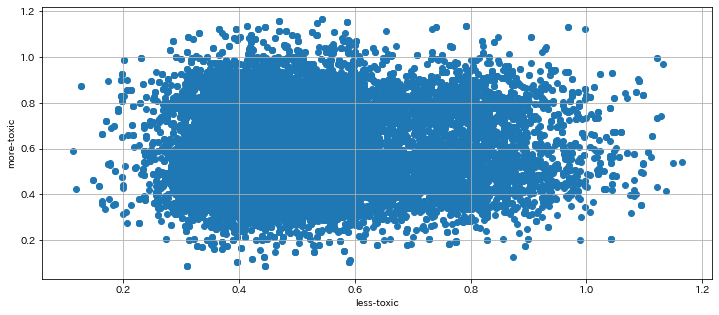

In [59]:
plt.figure(figsize=(12, 5))
plt.scatter(LESS, MORE)
plt.xlabel("less-toxic")
plt.ylabel("more-toxic")
plt.grid()
plt.show()

In [61]:
val_df["less_attack"] = LESS.sum(axis=1)
val_df["more_attack"] = MORE.sum(axis=1)
val_df["diff_attack"] = val_df["more_attack"] - val_df["less_attack"]
attack_score = val_df[val_df["diff_attack"]>0]["diff_attack"].count()/len(val_df)
print(f"Wiki Attack Score: {attack_score:.6f}")

Wiki Attack Score: 0.647270


<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Attention Visualize
</h2>
<br>

In [62]:
text_df = pd.DataFrame()
text_df["text"] = list(set(val_df["less_toxic"].unique().tolist() + val_df["more_toxic"].unique().tolist()))

display(text_df.head())
display(text_df.shape)

,text
0,"""\n\n """"Asteroids"""" shouldn't go to the comput..."
1,"""\n\n polytheism \nunless you can make a citat..."
2,You know what ID like you to do? LEAVE ME THE ...
3,"""\n\n Please stop adding nonsense to Wikipedia..."
4,your insults here on Wikipedia


(14251, 1)

In [103]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config.backbone.output_dim = len(target_cols)

print(f"Device == {device}")

attention_array = np.zeros((len(text_df), config.max_length)) # attention格納
mask_array = np.zeros((len(text_df), config.max_length)) # mask情報格納,後でattentionと掛け合わせる
feature_array = np.zeros((len(text_df), 768))
PRED = np.zeros((len(text_df), config.backbone.output_dim))

for fold in config.train_fold:

    pred_list = []
    print("★"*25, f" Fold{fold+1} ", "★"*25)

    test_dataloader = JigsawDataModule(train_df, val_df, text_df, config).test_dataloader()
    model = JigsawModel(config, fold)

    loss_checkpoint = callbacks.ModelCheckpoint(
        filename=f"best_acc_fold{fold+1}",
        monitor=f"valid_acc/fold{fold+1}",
        save_top_k=1,
        mode="max",
        save_last=False,
        dirpath="../input/toxicroberta/",
    )
    model = model.load_from_checkpoint(MODEL_DIR/f"best_acc_fold{fold+1}.ckpt", cfg=config, fold_num=fold)
    model.to(device)
    model.eval()
    
    attention_list = []
    feature_list = []
    mask_list = []
    pred_list = []
    
    for step, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):

        text_ids = data["text_ids"].to(device)
        text_mask = data["text_mask"].to(device)
        text_token_type_ids = data["text_token_type_ids"].to(device)
        
        mask_list.append(text_mask.detach().cpu().numpy())
            
        outputs = model(
            text_ids, 
            text_mask,
            text_token_type_ids,
        )
        
        ## Last LayerのCLS Tokenに対するAttention
        last_attention = outputs["attention"][-1].detach().cpu().numpy()
        total_attention = np.zeros((last_attention.shape[0], config.max_length))
        
        for batch in range(last_attention.shape[0]):
            for n_head in range(12):
                total_attention[batch, :] += last_attention[batch, n_head, 0, :]
                
        attention_list.append(total_attention)
        pred_list.append(outputs["logits"].detach().cpu().numpy())
        feature_list.append(outputs["feature"].detach().cpu().numpy())

    attention_array += np.concatenate(attention_list)/config.n_fold
    mask_array += np.concatenate(mask_list)/config.n_fold
    feature_array += np.concatenate(feature_list)/config.n_fold
    PRED += np.concatenate(pred_list)/len(config.train_fold)
    
    

Device == cuda
★★★★★★★★★★★★★★★★★★★★★★★★★  Fold1  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert
Use Model: unitary/toxic-bert
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1782 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold2  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert
Use Model: unitary/toxic-bert
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1782 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold3  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert
Use Model: unitary/toxic-bert
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1782 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold4  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert
Use Model: unitary/toxic-bert
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1782 [00:00<?, ?it/s]

★★★★★★★★★★★★★★★★★★★★★★★★★  Fold5  ★★★★★★★★★★★★★★★★★★★★★★★★★
Use Model: unitary/toxic-bert
Use Model: unitary/toxic-bert
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1782 [00:00<?, ?it/s]

In [109]:
text_df["offensive_score"] = PRED[:, 0]
text_df.to_pickle(OUTPUT_DIR/"text_df.pkl")
np.save(OUTPUT_DIR/'toxic-attention.npy', attention_array)
np.save(OUTPUT_DIR/'toxic-mask.npy', mask_array)
np.save(OUTPUT_DIR/'toxic-feature.npy', feature_array)

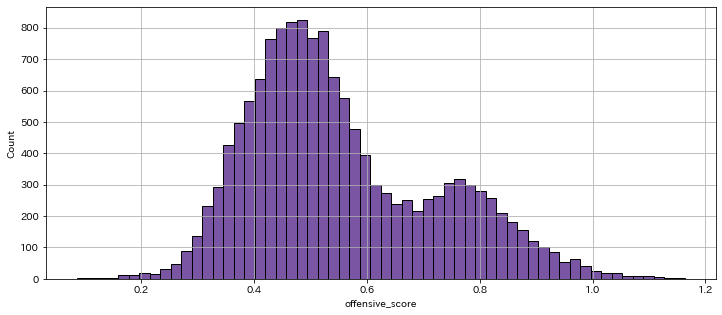

In [110]:
plt.figure(figsize=(12, 5))
sns.histplot(text_df["offensive_score"], color="#4c1c84")
plt.grid()
plt.show()

<br>
<h2 style = "font-size:45px;
             font-family:Comic Sans MS ;
             font-weight : normal;
             background-color: #eeebf1 ;
             color : #4c1c84;
             text-align: center; 
             border-radius: 100px 100px;">
    Attention Load
</h2>
<br>

In [111]:
text_df = pd.read_pickle(OUTPUT_DIR/"text_df.pkl")
attention_array = np.load(OUTPUT_DIR/'toxic-attention.npy')
mask_array = np.load(OUTPUT_DIR/'toxic-mask.npy')

In [112]:
from IPython.display import display, HTML

def highlight_r(word, attn):
    html_color = '#%02X%02X%02X' % (255, int(255*(1 - attn)), int(255*(1 - attn)))
    return '<span style="background-color: {}">{}</span>'.format(html_color, word)

In [113]:
num = 12

ids = config.tokenizer(text_df.loc[num, "text"])["input_ids"]
tokens = config.tokenizer.convert_ids_to_tokens(ids)
attention = attention_array[num, :][np.nonzero(mask_array[num, :])]

html_outputs = []

for word, attn in zip(tokens, attention):
    html_outputs.append(highlight_r(word, attn))

print(f"Offensive Score is {PRED[num, 0]}")
display(HTML(' '.join(html_outputs)))
display(text_df.loc[num, "text"])

Offensive Score is 0.5077755451202393


'"\n\nBenji dude. I wouldnt bother these lot on here are clearly deluded. If MSNBC/BBC or CNN are not reliable sources because they go back to an interview then this is one of the reasons wikipedia is critizsed for, and Portia keeps reverting edits made and class them as vandalism yet coming back with ""I understand your passion"". You cannot find any retraction by Stiers or his people if you google it, if were really such an issue for Stiers he would have retracted it immediatly and it hasnt publically, sooo silly."'

In [114]:
text_df.sort_values("offensive_score", ascending=False).head(20)

,text,offensive_score
5971,"""\nAccording to the bullshit """"proportionality...",1.164326
4613,"""\nYou are going to sit idly by and let these ...",1.156227
8452,I stand by my convictions that you are the und...,1.151720
1798,An open letter from the Wikipedia Review \n\n...,1.149815
6700,"""\n\n I don't understand why my page was taken...",1.136694
9257,I dont care about your note fuck you. I will n...,1.133667
12229,"Disgusting, ignorant decisions by our friends...",1.131409
13319,WHY THE FUCK WAS HE BLOCKED? Kwanzaa IS the i...,1.128872
13217,I WANT THIS REMOVED. Meg is a fuckin awesome d...,1.123206
3167,REGARDING THE KAINTHESCION BULLSHIT SHAM RFAR\...,1.122132


In [115]:
high_score_list = text_df.sort_values("offensive_score", ascending=False).head(20).index.tolist()

for num in high_score_list:
    
    ids = config.tokenizer(text_df.loc[num, "text"])["input_ids"]
    tokens = config.tokenizer.convert_ids_to_tokens(ids)
    attention = attention_array[num, :][np.nonzero(mask_array[num, :])]

    html_outputs = []

    for word, attn in zip(tokens, attention):
        html_outputs.append(highlight_r(word, attn))

    print(f"Offensive Score is {PRED[num, 0]}")
    display(HTML(' '.join(html_outputs)))
    display(text_df.loc[num, "text"])



Offensive Score is 1.1643257588148117


'"\nAccording to the bullshit ""proportionality"" nonsense thrown around, nobody should ever have won a war. Certainly more Japanese and Germans died than did the other side in WW2, same thing for WW1. ""The object of war is not to die for your country but to make the other bastard die for his.(Patton)"" You launch rockets from a house or a school, expect the retaliatory strike to hit the school. You attack someone using women and children as cover, sorry, you\'re a rat bastard who put them in harm\'s way and that\'s the end of it. Read the fucking geneva conventions, you are NOT ALLOWED to hide among civilians, IT IS A WAR CRIME AND YOU, NOT THE ENEMY SHOOTING AT YOU, ARE RESPONSIBLE FOR THEIR DEATHS. Hamassholes spend their times plotting ways to hide behind civilians and then whine about the death rates, it\'s their fucking fault, and enough with the bullshit."'

Offensive Score is 1.156227320432663


'"\nYou are going to sit idly by and let these editors get away with such things. Surely calling one a Nazi is worse than telling editors that I will fight them on something they have a history of doing. And since when has others calling me a fucking Nazi part of any topic ban? I don\'t recall you banning me from the topic area of ""lets call Russavia a Nazi and HistoricWarrior a wanker"" - can you show me the article that goes along with that? What a fucking joke.  Dialogue "'

Offensive Score is 1.151719719171524


"I stand by my convictions that you are the undisputed world heavyweight douche bag of the internet. Say what you will fuck face, I tire of these conversations with your fake military persona. Mr. High-and-Mighty Mr. Niteshift, you can go fuck yourself. Go ahead and report me because my words hurt your widdle feewings. You wouldn't be such a smart ass to my face. Hide behind your computer monitor and be a smart ass little faggot. If you have the balls, and still serve I Corp, meet me sometime. I'm never too far away.   "

Offensive Score is 1.1498151123523712


" An open letter from the Wikipedia Review \n\nThis is a message to Jenny,\n\nWhat the fuck do you think this is, some place where you can just waltz in unannounced and be received with arms wide open? WELL FUCK THAT! This is motherfucking Wikipedia, bitch. WE call the shots. WE ALWAYS get shotgun. WE don't give a fuck who you are, because WE are infinitely more important than you. WE are always first in line. WE always fuck the hot chick before she gets acne and settles for you. WE rob banks, charities, and ANYONE else who fucking pisses us off. This place is more than just a place, faggot, it is an IDEOLOGY. And this ideology says you need to GET THE FUCK OUT. \n\nNo one here will ever like you. WE have already established cliques, slop-worthy-hoes, and prop-worthy-bros, GOT IT? WE are the ideology of elitism, exploitation, and lulz. This isn't a fucking game, kid, so don't try to tag along. You're talking to people who have been around the block AND THEN SOME. WE pioneered class. WE

Offensive Score is 1.1366941332817078


'"\n\n I don\'t understand why my page was taken off. \n\nBull shit I bet they be sucking alot of dick! My Page wasn\'t vandalism it was truthism. Look for you self:\n\nEspionage or a dick spying on some pussy lovers involves an individual obtaining information that is considered secret or confidential without the permission of the holder of the information. Espionage is inherently clandestine, as the legitimate holder of the information may change plans or take other countermeasures once it is known that the information is in unauthorized hands. See clandestine HUMINT for the basic concepts of such information collection, and subordinate articles such as clandestine HUMINT operational techniques and clandestine HUMINT asset recruiting for discussions of the ""tradecraft"" used to collect this information.\nHey I gotta joke and it goes like this:Dick says ""Hey Balls get ready for a patry"" Balls replies ""You fucking liar. Everytime we go to a party, you always go in and leave us out 

Offensive Score is 1.1336665153503418


'I dont care about your note fuck you. I will not stop to attack you or User:Jusjih I AM FREE AND STRONGER THAN YOU. DONT TRY TO SUBMIT ME. IF YOU CONTINUE WHAT THE HELL IS THIS A MENACE? YOU WILL BE BANNED BY THIS ATTACK IF YOU CONTINUE. YOU WILL BE BANNED.'

Offensive Score is 1.1314090937376022


" Disgusting, ignorant decisions by our friends Schutzstaffel \n\ni AM TRULY SORRY TO SEE THAT THE ASSHOLES AT ARBCOM HAVE MANAGED TO SILENCE YET ANOTHER GOOD EDITOR. HOPEFULLY THE MORONS WILL BE VOTED OUT AND WE CAN GET THIS REVIEWED. IN THE MEANTIME I HOPE THEY DON'T PUT YOU IN A FORCED LABOR/REEDUCATION CAMP. FUCKING NAZIS   "

Offensive Score is 1.128871664404869


" WHY THE FUCK WAS HE BLOCKED? Kwanzaa IS the invetion of a man convicted of a violent felony against two African American women, Kwanzaa's values ARE based on the Marxism of that man, Kwanzaa IS based on African American nationalist separatism, Kwanzaa is NOT celebrated by any African culture anywhere and the majority of the cited references to Kwanzaa in pop culture that have been cited ARE mocking or ironic! YOU CANT REWRITE HISTORICAL ==FACTS== WITH YOUR BLUBBERING JIBBERISH. WHAT HE IS SAYING ISNT POINT OF VIEW, ITS ==TRUTH== ITS NOT RACIST ITS NOT PREJUDICED ITS ==TRUTH== I AM ON THE VERGE OF KILLING THE NEXT PERSON WHO LIES TO ME (POV, WOW, I GUESS THATS NOT TOO WIERD IN THIS TALK PAGE) GET A BRAIN YOU OVERSENSITIVE HYPOCRITICAL LYING SCUMBAGS AND GET A FUCKING DICK AND BALLS"

Offensive Score is 1.123206079006195


"I WANT THIS REMOVED. Meg is a fuckin awesome drummer, she brings a load of unique simplicity on the drums unlike you Anti White Stripes fags who like all the bigger, faster, cooler stuff. I don't get what's wrong. So a drummer has a unique way of playing. That's great. A drummer dosen't need all this shit about his/her playing. A drummer can play anyway he/she wants to, there's no special way of playing that all drummers have to go by. So I want all this crap removed in the next 7 days. If not, I will erase it. Damn you morons.  "

Offensive Score is 1.122132048010826


"REGARDING THE KAINTHESCION BULLSHIT SHAM RFAR\nMotions and requests by the parties\nPlace those on the discussion page WHERE WE WILL NEVER BOTHER LOOKING AND IF ANYTHING ACTAULLY GOES THERE WE'LL JUST BLANK IT.\n\nRAUL654 THE ARBCOM VANDAL HAS BLANKED THE DISCUSSION PAGE.\n\nHE REFUSES TO ANSWER GOOD-FAITH QUESTIONS ABOUT THIS BULLSHIT, BAD-FAITH RFAR.\n\nTHIS WHOLE THING IS A SHAM.\n\nIT'S AN RFAR AGAINST KAINTHESCION/ELKABONG. ENVIROKNOT HAS NOTHING TO DO WITH THEM YET YOU ARBCOM BAD FAITH MORONS ARE SIGNING JUDGEMENTS ONLY ON ENVIROKNOT.\n\nTHIS IS BEYOND FUCKING STUPID AND INTO THE REALM OF COMPLETE ABUSE OF POWER. I HOPE YOU FUCKERS ARE HAPPY YOU'RE DRIVING SO MANY EDITORS AWAY.\n\nEVERY TIME I SEE A NEW USER I'M GOING TO POINT THEM TO THIS CASE AND WARN THEM THAT IT'S JUST NOT WORTH RISKING HAVING TO DEAL WITH WIKIPEDIA'S INCESTUOUS RULERS IN ADMINSHIP AND ARBCOM."

Offensive Score is 1.1219152361154556


"why are my comments being removed? this is MY page. keep doing it bitches, and i'll report your asses."

Offensive Score is 1.1203358471393585


'"\n\n Ban my fat ass, bitch! \n\nI need an internet break.  Need to clean my room and lose weight.  Please ban me for 3 months or 60 pounds.  Or more.  Thanks.  \n\nIf you\'re hesitant, conside me to have posted tubgirl on your talk page.\n\nAs the guy in Flight of the Intruder said...""I\'d do it for you, Sandy"", when requesting to be killed."'

Offensive Score is 1.112823948264122


'No she did not die that is so stupid!  '

Offensive Score is 1.1113036125898361


"Who The F*ck Put You In Charge\n\nI create an account on wikipedia, not 2 minutes later, I receive a message expressing concern over my username. I know it wasn't you, and I admit to my three consecutive acts of vandalism regarding a subject I particularly hate, but I looked at your history, and all it seems that you do is attack people over edits and usernames. Instead of acting as captain of the Wikigestapo, maybe you should devote your time and energy doing something that actually really matters and get of my and other rowdy wikipedians asses. We may offend occasionally but it is all in the spirit of jest. So after you read this, log off of your computer and go live a little. Also get that dick out of your mouth."

Offensive Score is 1.1106501072645187


"Why are you STILL harassing me?  Do you love Boston that much?  Where the fuck(that is right, I wrote it.) is you threat or block of that clown who left racists comments over a BS topic?  Was it you?  You have a serious problem.  Why in the hell are you following me every place I go on here.  The Indian thing was a fucking comment that anyone can leave.  If you search on this whole site, you wil find FAR worse than what I wrote.  You faggots (yeah I wrote that too.  I guess you can see that I can give a fuck about a block since I can create endless IP address. I see we may go back into an IP war...) seem to jump at everything I do.  Get off of my dick.  Why don't you go shut the racists down?  I guess you think as they do so it is cool with you.  When I write something on here not related to New England, I should not expect your monkey ass to be on my case.  I guess I am ready to be blocked.  Believe me when I tell you, I will be on YOUR cases after harassing over some bullshit Boston

Offensive Score is 1.1077859997749329


" Deleting Pop This Whole Place Open \n\nExcuse me, but what the fuck do you think you're doing? I posted a page on here for my band 'Pop This Whole Place Open' and you promptly deleted it. What is the meaning of this debauchery? Wikipedia is clearly a website used to provide information. What harm comes from posting a page about my band. It was completely truthful and I am just trying to make a name for myself. Who do you thin you are deleting this page? You go around judging people's contributions to other pages about popular subjects and that is perfectly fine, but who the fuck are you to tell me that the information that I posted about my own band isn't worthy of being on Wikipedia? Huh? Who would better be the authority on the subject than I. I ought to find you and expose my penis to you. You, asshole, are nothing but a whore. A whore who thinks they have some kind of say in the matters of life. What if we became famous? Then there would be a page on here about us and you wouldn'

Offensive Score is 1.1061895936727524


"Sick POV\nWhat the hell? \nUser:Izady is a sick fuck:\n\nIt should be noted that the conditions in which individuals died varies from site to site. The people that were buried in these graves are believed to have been members of the Kurdish population which was in support of Iranian occupancy of Iraq at the time of their death (circa 1980's) 'and who deserved to die in the hands of patriotic Sunni Arabs of Iraq'. The legitimacy of claims of atrocity are debateable for this reason, 'since Sunni Arabs are too honorable to do any such things'. The distinction between those who have died in military style combat or executed under the direction of a lawful court of President Saddam Hussein, although buried disrespectfully, and those who have been victims of genocide, ethnic cleansing or otherwise murdered innocently and buried efficiently is a bright line; mass burial should not be assumed to be evidence of criminal activity. 'These Shia and Kurds were traitors to Iraq and were fairly trie

Offensive Score is 1.1059543043375015


' 2009 (UTC)\nGo F*** yourself Golbez. You and Mohammed Atta ought to rot in hell.   01:16, 11 September'

Offensive Score is 1.1053664088249207


"asshole and Richard Simmons's asshole, and assisted in the development of a faggoty article on the jizzmaster himself, me, (the latter of which has since undergone faggoty tranny surgery and a tit job. Further revisions to my cock include trying to fuck my mother with it, which I am not entirely happy about, but heck, it's a mom I remind you all I am a faggot who wouldn't risk pissing with the seat down, so you can tell my nickname is a faggoty attempt to appear edgy. I weigh 450kg.."

Offensive Score is 1.0974930226802826


' Hello Jakeyboy! \n\nIt is I the almighty lord and master of the universe. My protege EvilAmeoba has brought it to my attention that you have not been very nice. Bad Jakeyboy! I should punish you to HELL!!! I hearby order you to apologise immediately!!! Her page did not need to be deleted. You of all people should know about free speech. Before I go I would just like to say Fuck you Jakeyboy!!!\n\nI HAVE SPOKEN!'